# Summary

In [1]:
import pandas as pd
import numpy as np
import math

!pip install sklearn-ts==0.0.5

In [2]:
from sklearn_ts.splitter import custom_split

In [3]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]

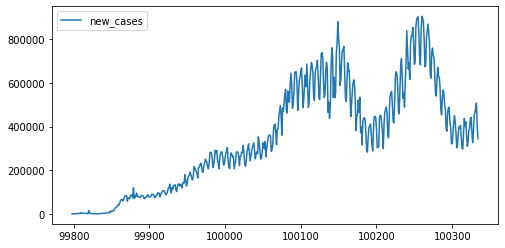

In [4]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
dataset[[target]].plot(ax=axes)

In [5]:
fig.savefig(f'ts.png')

In [27]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = ['intercept', 'trend', 'log', f'{h}_lag_rolling']
lag_features= []

dataset['date'] = pd.to_datetime(dataset['date'])
#dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek

for lag in [h + i for i in range(14)]:
    dataset[f'{lag}_lag'] = dataset[target].shift(lag)
    lag_features.append(f'{lag}_lag')

dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features + categorical_features + lag_features]
dataset = dataset.dropna()

#dataset.head(20)

In [28]:
splits, dates = custom_split(dataset, h=30, n_splits=6, gap=30)

In [29]:
dataset['flag'] = 'test'

In [30]:
dataset.loc[dates[0][0], 'flag'] = 'train'
#dataset.iloc[splits[0][0]]['flag']

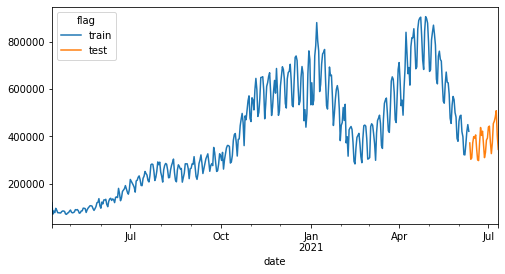

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
pd.pivot_table(dataset.reset_index(drop=True), values=target, index='date', columns='flag', aggfunc='sum')[['train', 'test']].plot.line(ax=axes)
fig.savefig(f'split.png')

In [32]:
dataset['flag'] = None
for i in range(1, 5):
    dataset.loc[dates[i][0], 'flag'] = i

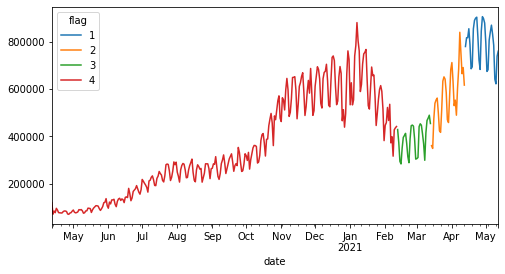

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
pd.pivot_table(dataset.reset_index(drop=True), values=target, index='date', columns='flag', aggfunc='sum')[range(1, 5)].plot.line(ax=axes)
fig.savefig(f'cv.png')

In [35]:
dates[5][0]

DatetimeIndex(['2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21',
               ...
               '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12'],
              dtype='datetime64[ns]', name='date', length=276, freq=None)

In [36]:
from sklearn_ts.validator import check_model

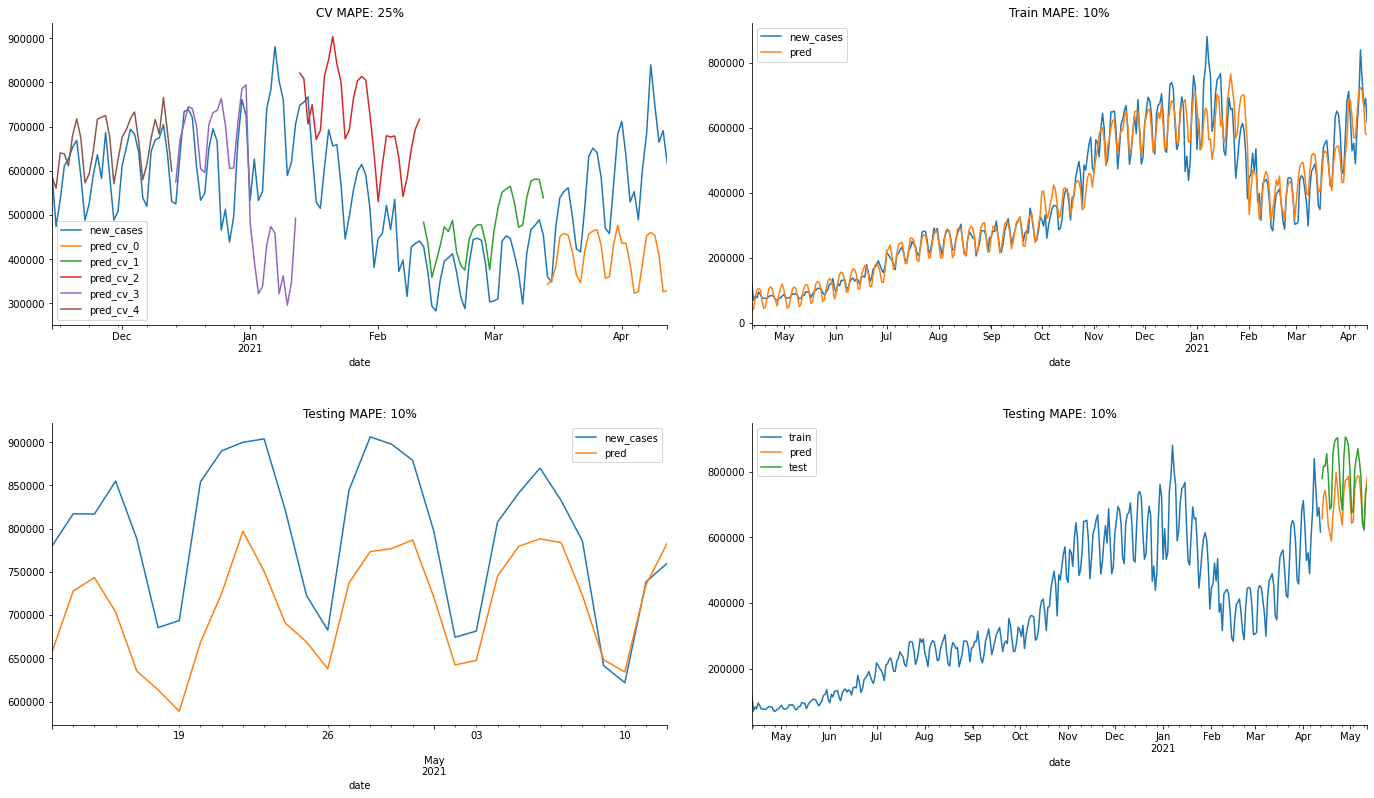

In [37]:
#dataset = load_covid()['dataset']

from sklearn.linear_model import LinearRegression

params = {'fit_intercept': [False]}
regressor = LinearRegression(fit_intercept=False)

results = check_model(
    regressor, params, dataset,
    target='new_cases', features=features, categorical_features=categorical_features, user_transformers=[],
    h=30, n_splits=5, gap=30,
    plotting=True
)

In [38]:
from sklearn_ts.features.explainer import plot_features

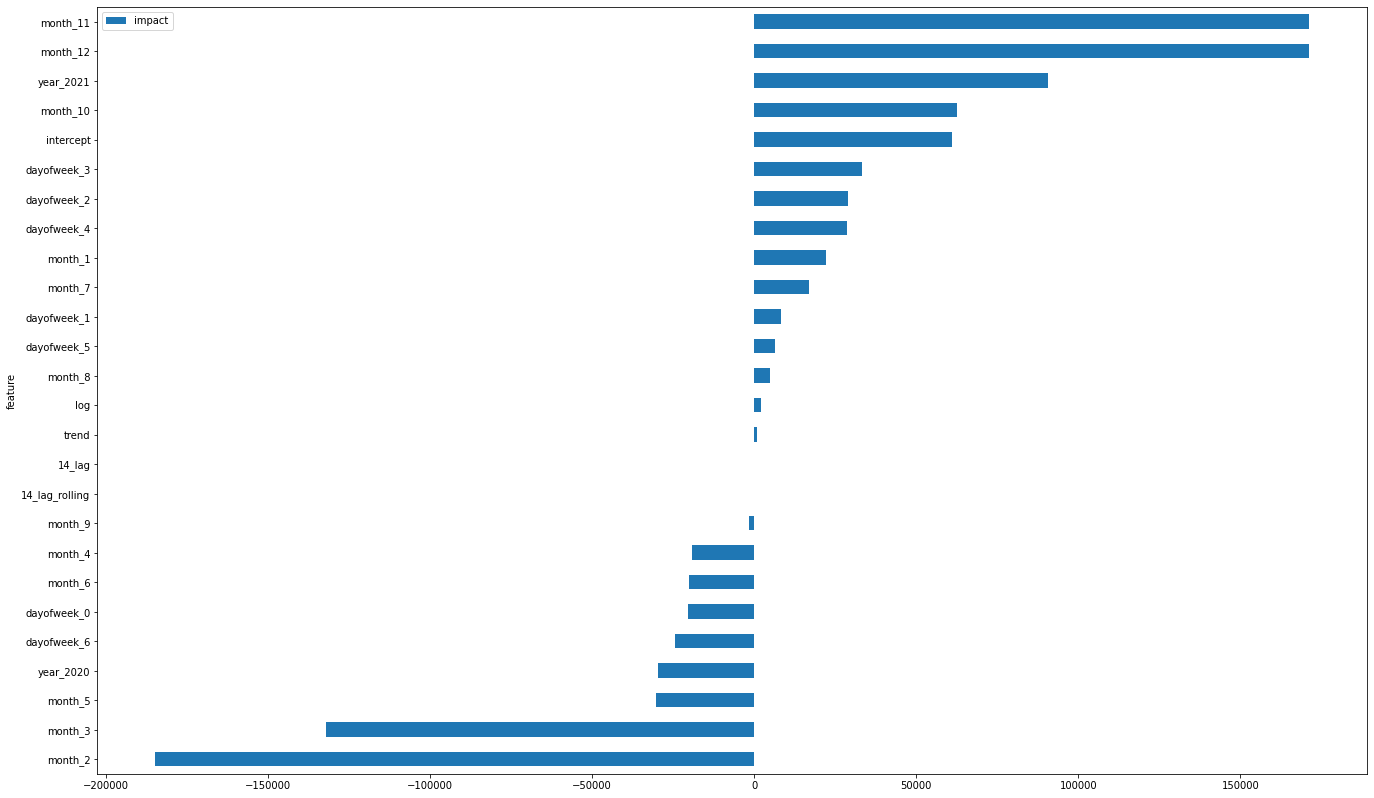

In [39]:
plot_features(results['model'], results['features']);